# Reddit Datasets

## Using PRAW and Pushshift to download Reddit data

There are currently three Reddit datasets available to download, which can be accessed from  https://berkeley-politics-capstone.s3.amazonaws.com/reddit.zip :

* `reddit_2016_05_31.pkl`: Contains the post id, number of comments, karma score, subreddit, number of subscribers in that subreddit, title of post link, and url of article links posted to /r/politics and a couple of the specific Republican candidates' subreddits from January 1, 2015 to May 31, 2016 (Trump won delegate majority in late May 2016).
* `reddit_2019_06_15.pkl`: Contains the post id, number of comments, karma score, subreddit, number of subscribers in that subreddit, title of post link, and url of article links posted to /r/politics and a couple of the specific Democratic candidates; subreddits from January 1, 2019 to June 15, 2019
* `reddit_headline_counts.csv`: Contains how many times a candidate's name was mentioned in a /r/politics, /r/news, or /r/worldnews post from January 1, 2019 to June 2019.

In [152]:
# Libraries

import requests
import praw
import configparser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import json
import os
from datetime import datetime, timedelta, date
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

## PRAW API - a Python wrapper to access Reddit 

This Python wrapper API can look at a subreddit and pull information such as the title, url, and body of a post (if it's not a link post). We can also get the karma score, the number of comments, and when the post was created.

This API needs credentials in order to run. I have stored the credentials away in an INI file that will not be uploaded to Github.

In [ ]:
# The following cells uses an INI file to pull in credentials needed to access the PRAW API.
# This INI file is stored locally only

config = configparser.RawConfigParser()
config.read("config.txt")
reddit = praw.Reddit(client_id=config.get("reddit","client_id"),
                     client_secret=config.get("reddit","client_secret"),
                     password=config.get("reddit","password"),
                     user_agent="Political exploration",
                     username=config.get("reddit","username"))


In [ ]:
# Example data pull

posts = []

for post in reddit.subreddit('politics').hot(limit=10):
    posts.append([post.title, 
                  post.score, 
                  post.id, 
                  post.subreddit, 
                  post.url, 
                  post.num_comments, 
                  post.selftext, 
                  datetime.utcfromtimestamp(post.created)
                 ])
df = pd.DataFrame(posts,
                     columns=['title', 
                              'score', 
                              'id', 
                              'subreddit', 
                              'url', 
                              'num_comments', 
                              'body', 
                              'created'
                             ])

df

## Pushshift API - a free API with no credentials needed

Pushshift API is more useful to gather aggregate data of a metric in a subreddit, such as number of times a query is mentioned, or to gather a field that meets certain conditions. Additionally, Pushshift is free to use and does not require any credentials.

See https://www.reddit.com/r/pushshift/comments/bcxguf/new_to_pushshift_read_this_faq/ for more helpful information.

### List of URLs

Most of the time in /r/politics, users submit link posts to articles. We'd like to gather a list of these articles so that we may use the `news-please` library to grab the text and subsequently do NLP on it. To get this list, I've used Pushshift and used the following call: 

https://api.pushshift.io/reddit/submission/search/?subreddit=politics&after=2019-06-01&before=2019-06-10&is_self=false&filter=title,subreddit,url,score,num_comments,subreddit_subscribers,id&limit=1000

Note about subreddits: Michael Bennet, Steve Bullock, Julián Castro, Bill de Blasio, John Delaney, John Hickenlooper, Seth Moulton, Tim Ryan, Eric Swalwell, Marianne Williamson, and Andrew Yang are candidates who do not have dedicated subreddits as of May 30, 2019.

In [41]:
# Initial step: Creating the list

output = pd.DataFrame(columns=['id','num_comments','score','subreddit','subreddit_subscribers','title','url'])

In [92]:
# Set the date range

start_date = date(2016, 5, 1)

#day_count = (date(2019, 6, 15) - start_date).days + 1 # The last time I pulled the 2019 dataset together

day_count = (date(2016, 5, 30) - start_date).days + 1 # For use with the 2015 dataset


# Set the subreddits to go through

subreddits = {'Joe Biden': 'JoeBiden',
              'Cory Booker': 'corybooker',
              'Pete Buttigieg': 'Pete_Buttigieg',
              'Tulsi Gabbard': 'tulsi',
              'Kirsten Gillibrand': 'Kirsten_Gillibrand',
              'Mike Gravel': 'gravelforpresident',
              'Kamala Harris': 'Kamala',
              'Jay Inslee': 'inslee2020',
              'Amy Klobuchar': 'BaemyKlobaechar',
              'Beto O\'Rourke': 'Beto2020',
              'Bernie Sanders': 'SandersForPresident',
              'Donald Trump': 'The_Donald',
              'Elizabeth Warren': 'ElizabethWarren',
             'politics': 'politics'}

# Subreddits for 2016 candidates

subreddits_2016 = {'Donald Trump': 'The_Donald',
                   'Ted Cruz': 'TedCruz',
                   'Jeb Bush': 'JebBush',
                   'Ben Carson': 'BenCarson',
                   'Chris Christie': 'ChrisChristie',
                   'Jon Kasich': 'KasichForPresident',
                   'Rand Paul': 'RandPaul',
                   'Marco Rubio': 'Marco_Rubio',
                   'politics': 'politics'}

# For loop that iterates through the day to get 1000 link posts, then scrapes some choice domains away

for single_date in (start_date + timedelta(n) for n in range(day_count)):
    
    after = single_date.strftime("%Y-%m-%d")
    before = (single_date + timedelta(1)).strftime("%Y-%m-%d")
    
    for subreddit in subreddits_2016.values():
    
        url = 'https://api.pushshift.io/reddit/submission/search/?subreddit={0}&after={1}&before={2}&is_self=false&filter=id,title,subreddit,url,score,num_comments,subreddit_subscribers&limit=1000'.format(subreddit,after,before)

        r = requests.get(url)
        
        if r.status_code != 200:
            continue
            
        else:
            response = r.json()
        
            if bool(response['data']):
                temp = pd.DataFrame.from_dict(response['data'], orient='columns')
                output = output.append(temp, ignore_index = True)


In [93]:
# Remove non article URLs

remove = ['twitter.com','hbo.com','youtube.com','youtu.be','reddit.com','streamable.com','imgur.com',
                         'i.imgur.com','forgifs.com','i.redd.it']
searchrm = '|'.join(remove)

output = output[~output['url'].str.contains(searchrm)].reset_index(drop=True)

In [95]:
#output.to_pickle('reddit_2016_05_31.pkl')

## Feature Engineering

Possible ideas include:

1. Number of average and cumulative posts in a subreddit, but the API doesn't make this easy to get.
2. The karma/score and number of comments for an associated headline.
3. Topic modeling on the headline
4. What candidate is addressed in the headline
5. Sentiment analysis on the headline
6. Counting if the word "donation" is referenced in the headline (better yet, the comments)

In [ ]:
# Using id = buf84a as a test

sample_post = reddit.submission(id='buf84a')

sample_post.title

## Logistic Regression

Will be switching over to Pushshift API for this process, which allows us to get data between dates

Example call: https://api.pushshift.io/reddit/submission/search/?after=2019-06-02&before=2019-06-03&q=trump&sort_type=score&sort=desc&subreddit=politics&limit=500

Where the output is a JSON file, the after date is the date of interest, and the before date is one date in the future.

### Headline mentions vs donations
#### Consider calculating the cumulative karma score and comments along with this later on

The Pushshift API call used here will rely on `agg=subreddit` to get counts and will look like the following:

https://api.pushshift.io/reddit/submission/search/?subreddit=politics,news,worldnews&aggs=subreddit&q=trump&size=0&after=2019-06-02&before=2019-06-03

This data will be stored in a csv file that can be pulled in later: `mentions = pd.read_csv('reddit_headline_counts.csv')`

In [ ]:
politicians = ['williamson', 'harris', 'buttigieg', 'klobuchar', 'yang', 'gillibrand', 'delaney', 'inslee', 
               'hickenlooper', 'o\%27rourke', 'warren', 'castro', 'sanders', 'gabbard', 'booker', 'trump', 'biden']

# Set the date range

start_date = date(2019, 3, 8)

day_count = (date(2019, 3, 14) - start_date).days + 1

# Set the rows_list holder
rows_list = []

# For loop that iterates through the day to get 1000 link posts, then scrapes some choice domains away

for single_date in (start_date + timedelta(n) for n in range(day_count)):
    
    after = single_date.strftime("%Y-%m-%d")
    before = (single_date + timedelta(1)).strftime("%Y-%m-%d")
    
    for candidate in politicians:
        url = 'https://api.pushshift.io/reddit/submission/search/?subreddit=politics,news,worldnews&aggs=subreddit&q={0}&size=0&after={1}&before={2}'.format(candidate,after,before)
        response = requests.get(url).json()
        
        for thing in response['aggs']['subreddit']:
            dict1 = {}
            dict1.update({'date': after, 
                          'candidate': candidate, 
                          'subreddit': thing['key'], 
                          'doc_count': thing['doc_count']})
            rows_list.append(dict1)
            
mentions = pd.DataFrame(rows_list)

In [99]:
#mentions

#mentions.to_csv('mar8tomar14.csv',index=False)

# To reload, use:
mentions = pd.read_csv('../../data/reddit/reddit_headline_counts.csv')

In [104]:
# O'Rourke candidate name change

mentions = mentions.replace('o\%27rourke', 'orourke')
by_politics = mentions[mentions['subreddit']=='politics']

In [106]:
# From Andrew:
# find the path to each fec file, store paths in a nested dict
fec_2020_paths = {}
base_path = os.path.join("..","..","data","fec","2020") # This notebook was one more level down
for party_dir in os.listdir(base_path):
    if(party_dir[0]!="."):
        fec_2020_paths[party_dir] = {}
        for cand_dir in os.listdir(os.path.join(base_path,party_dir)):
            if(cand_dir[0]!="."):
                fec_2020_paths[party_dir][cand_dir] = {}
                for csv_path in os.listdir(os.path.join(base_path,party_dir,cand_dir)):
                    if(csv_path.find("schedule_a")>=0):
                        fec_2020_paths[party_dir][cand_dir]["donations"] = \
                            os.path.join(base_path,party_dir,cand_dir,csv_path)
                    elif(csv_path.find("schedule_b")>=0):
                        fec_2020_paths[party_dir][cand_dir]["spending"] = \
                            os.path.join(base_path,party_dir,cand_dir,csv_path)
print(json.dumps(fec_2020_paths, indent=4))

{
    "republican": {
        "trump": {
            "spending": "../../data/fec/2020/republican/trump/schedule_b-2019-05-30T16_03_37.csv",
            "donations": "../../data/fec/2020/republican/trump/schedule_a-2019-05-30T16_03_37.csv"
        }
    },
    "democrat": {
        "williamson": {
            "spending": "../../data/fec/2020/democrat/williamson/schedule_b-2019-05-30T20_41_44.csv",
            "donations": "../../data/fec/2020/democrat/williamson/schedule_a-2019-05-30T20_41_32.csv"
        },
        "harris": {
            "spending": "../../data/fec/2020/democrat/harris/schedule_b-2019-05-30T17_22_09.csv",
            "donations": "../../data/fec/2020/democrat/harris/schedule_a-2019-05-30T17_19_58.csv"
        },
        "buttigieg": {
            "donations": "../../data/fec/2020/democrat/buttigieg/schedule_a-2019-05-30T17_32_11.csv",
            "spending": "../../data/fec/2020/democrat/buttigieg/schedule_b-2019-05-30T17_32_14.csv"
        },
        "klobuchar": {
 

In [132]:
dataset = pd.DataFrame()
for candid in fec_2020_paths["democrat"].keys():
    if("donations" in fec_2020_paths["democrat"][candid].keys()):
        
        # process donations dataset
        df1 = pd.read_csv(fec_2020_paths["democrat"][candid]["donations"])
        df1["contribution_receipt_date"] = pd.to_datetime(df1["contribution_receipt_date"]).dt.date
        df1 = df1.loc[df1["entity_type"]=="IND"]
        df1 = df1.loc[df1["contribution_receipt_amount"]<=2800]
        df1 = df1.groupby(by="contribution_receipt_date", as_index=False)["contribution_receipt_amount"].sum()
        df1.name = "individual_donations"
        df1 = pd.DataFrame(df1)
        df1["candidate"] = candid
        
        # attaching to the mentions dataset
        #result = mentions.merge(df1, how='inner', left_on=['', 'B'])

        
        # append to main df
        dataset = dataset.append(df1)

/Users/kanithamann/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kanithamann/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (35,36,37,38,39,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kanithamann/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (35,36,37,38,42,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/kanithamann/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (35) have mixed types. Specify dtype option on

In [136]:
dataset.rename(index=str, columns={'contribution_receipt_date':'date'}, inplace=True)

res = pd.merge(by_politics, dataset,  how='outer', left_on=['date','candidate'], 
                  right_on = ['date','candidate'])

res

,candidate,date,doc_count,subreddit,contribution_receipt_amount
0,harris,2019-01-01,1.0,politics,NaN
1,orourke,2019-01-01,1.0,politics,NaN
2,warren,2019-01-01,19.0,politics,NaN
3,sanders,2019-01-01,8.0,politics,NaN
4,gabbard,2019-01-01,1.0,politics,NaN
5,trump,2019-01-01,154.0,politics,NaN
6,biden,2019-01-01,2.0,politics,NaN
7,harris,2019-01-02,2.0,politics,NaN
8,klobuchar,2019-01-02,4.0,politics,NaN
9,inslee,2019-01-02,5.0,politics,NaN


In [142]:
# Replace NaN with 0

res['contribution_receipt_amount'].fillna(0, inplace = True) 
res['doc_count'].fillna(0, inplace = True) 
res

,candidate,date,doc_count,subreddit,contribution_receipt_amount
0,harris,2019-01-01,1.0,politics,0.00
1,orourke,2019-01-01,1.0,politics,0.00
2,warren,2019-01-01,19.0,politics,0.00
3,sanders,2019-01-01,8.0,politics,0.00
4,gabbard,2019-01-01,1.0,politics,0.00
5,trump,2019-01-01,154.0,politics,0.00
6,biden,2019-01-01,2.0,politics,0.00
7,harris,2019-01-02,2.0,politics,0.00
8,klobuchar,2019-01-02,4.0,politics,0.00
9,inslee,2019-01-02,5.0,politics,0.00


In [147]:
X_train = res["doc_count"].reshape(-1, 1)
y_train = res["contribution_receipt_amount"]
X_test = np.array(range(0,400)).reshape(-1, 1)
linear_fit = LinearRegression().fit(X_train, y_train)
y_pred = linear_fit.predict(X_test)

/Users/kanithamann/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.


In [148]:
linear_fit.score(X_train,y_train)

0.0035773008004679197

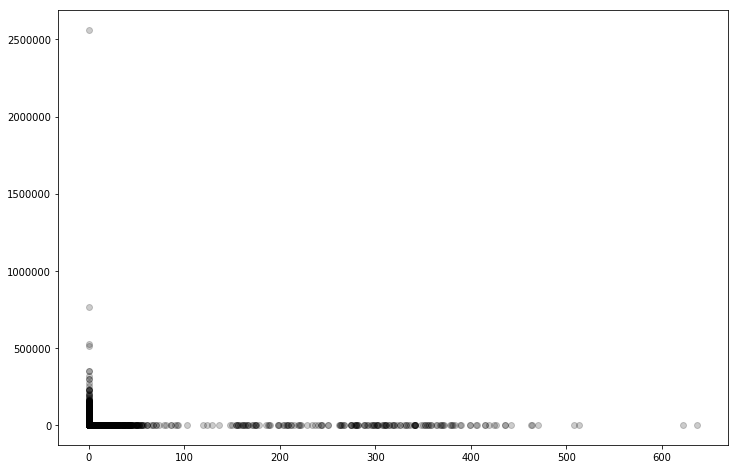

In [154]:
fix, ax = plt.subplots(figsize=(12,8))
plt.scatter(X_train, y_train,  color='black', alpha=0.2)
#plt.plot(X_test, y_pred, color='blue', linewidth=3)

If we want an aggregate of comments and score for this particular dataset later, I've been playing around with the following Pushshift API call: https://api.pushshift.io/reddit/submission/search/?subreddit=politics,news,worldnews&aggs=subreddit&q=trump&after=2019-06-02&before=2019-06-03&filter=subreddit,score,num_comments

## Sentiment Analysis

In [ ]:
sia = SIA()
results = []

for i in range(0,len(posts)):
    line = posts[i][0]
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    #results.append(pol_score)
    print(pol_score)

In [ ]:
# Save to a csv file if needed for the future

posts.to_csv('reddit_posts.csv', index=False) 